# StackExchange questions and Tags - Analysis

This Notebook is about Stackoverflow questions analysis in the goal of feature extraction and tagging
- I start by importing libraries and Data 
- I transform data from html to normal sentences
- I tokenize and clean my data
- I make some analysis on the data
- I take out stop words and make a stemming for body and title

## Libraries and frameworks

In [1]:
!pip install tqdm
!pip install flake8 --ignore-installed
!pip install pycodestyle_magic
!pip install wordcloud

  Using cached https://files.pythonhosted.org/packages/f8/1f/7ea40d1e4146ea55dbab41cda1376db092a75794914169aabd7e8d7a7def/flake8-3.7.9-py2.py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/84/f2/ed0ffb887f8138a8fe5a621b8c0bb9598bfb3989e029f6c6a85ee66628ee/pyflakes-2.1.1-py2.py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/0e/0c/04a353e104d2f324f8ee5f4b32012618c1c86dd79e52a433b64fceed511b/pycodestyle-2.5.0-py2.py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/ac/c6/44694103f8c221443ee6b0041f69e2740d89a25641e62fb4f2ee568f2f9c/entrypoints-0.3-py2.py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/87/89/479dc97e18549e21354893e4ee4ef36db1d237534982482c3681ee6e7b57/mccabe-0.6.1-py2.py3-none-any.whl


ERROR: spyder 3.3.6 requires pyqt5<5.13; python_version >= "3", which is not installed.
ERROR: spyder 3.3.6 requires pyqtwebengine<5.13; python_version >= "3", which is not installed.


In [145]:
import pandas as pd
import numpy as np

import logging
import warnings
from tqdm import tqdm

from wordcloud import WordCloud, STOPWORDS
from bs4 import BeautifulSoup
import nltk
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.tokenize.treebank import TreebankWordDetokenizer
import re
import string
import heapq

# sklearn for feature extraction
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from pprint import pprint
import scipy.sparse
import pickle

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import rcParams
import matplotlib.cm as cm
from matplotlib import pyplot as plt

# Enable logging for gensim - optional
logging.basicConfig(format='%(asctime)s :\
%(levelname)s : %(message)s', level=logging.ERROR)

warnings.filterwarnings("ignore", category=DeprecationWarning)

In [34]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\ayoub\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ayoub\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\ayoub\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\wordnet.zip.


True

In [4]:
tqdm.pandas()

In [5]:
%load_ext pycodestyle_magic
%pycodestyle_on
%matplotlib inline

plt.rcParams["patch.force_edgecolor"] = True
plt.style.use('fivethirtyeight')
mpl.rc('patch', edgecolor = 'dimgray', linewidth=1)

pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 200)

## Data import

In [6]:
df1 = pd.read_csv('C:/Users/ayoub/OCP6 Data/ndf1.csv')
df2 = pd.read_csv('C:/Users/ayoub/OCP6 Data/ndf2.csv')
df3 = pd.read_csv('C:/Users/ayoub/OCP6 Data/ndf3.csv')

In [7]:
df = pd.concat([df1, df2, df3])

Text(0.5, 1.0, 'Proportion of NaNs in each column')

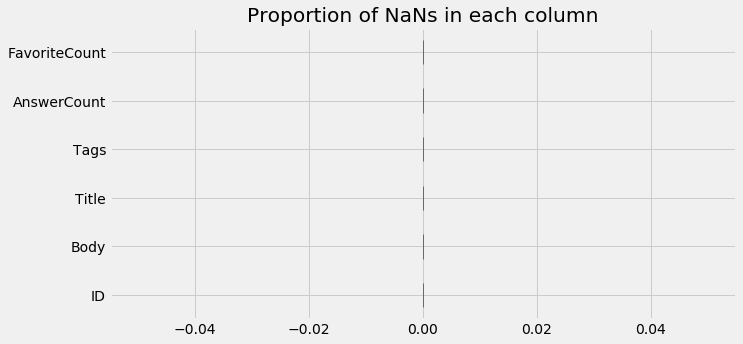

In [8]:
plt.figure(figsize=(10, 5))
df.isnull().mean(axis=0).sort_values().plot.barh()
plt.title("Proportion of NaNs in each column")

In [9]:
df.head()

,ID,Body,Title,Tags,AnswerCount,FavoriteCount
0,4,<p>I want to use a track-bar to change a form'...,Convert Decimal to Double,<c#><floating-point><type-conversion><double><...,13,50
1,6,<p>I have an absolutely positioned <code>div</...,Percentage width child element in absolutely p...,<html><css><internet-explorer-7>,6,11
2,9,<p>Given a <code>DateTime</code> representing ...,How do I calculate someone's age in C#?,<c#><.net><datetime>,61,443
3,11,<p>Given a specific <code>DateTime</code> valu...,Calculate relative time in C#,<c#><datetime><time><datediff><relative-time-s...,37,540
4,13,<p>Is there a standard way for a web server to...,Determine a user's timezone,<html><browser><timezone><user-agent><timezone...,24,147


In [10]:
df.drop(['ID'], axis=1, inplace=True)
df.dropna(subset=['Title'], inplace=True)
df.reset_index(drop=True, inplace=True)

## Cleaning and Feature engineering

In this part, I am going to transform th Body which is in html code format into text with BeautifulSoup

In [11]:
def html(code):
    return BeautifulSoup(code, 'lxml').text

In [12]:
df['Body'] = df.Body.progress_apply(html)

100%|██████████| 103676/103676 [00:34<00:00, 3004.38it/s]


In [13]:
df.Body[0]

"I want to use a track-bar to change a form's opacity.\nThis is my code:\ndecimal trans = trackBar1.Value / 5000;\nthis.Opacity = trans;\n\nWhen I build the application, it gives the following error:\n\nCannot implicitly convert type decimal to double\n\nI tried using trans and double but then the control doesn't work. This code worked fine in a past VB.NET project.\n"

### Tokenization
For tokenization we will :
- lower case for all the words
- remove <,>,><
- tokenize

In [14]:
tokenizer = nltk.RegexpTokenizer(r'\S+')

In [15]:
# Create a list to store the body data
tokens = []

# For each row in the column,
for row in tqdm(df['Body']):
    tokens.append(tokenizer.tokenize(row.lower()))

# Create a column from the list
df['tokens'] = tokens

100%|██████████| 103676/103676 [00:03<00:00, 26672.41it/s]


In [16]:
# Create a list to store the body data
ttokens = []

# For each row in the column,
for row in tqdm(df['Title']):
    ttokens.append(tokenizer.tokenize(row.lower()))

# Create a column from the list
df['title_tokens'] = ttokens

100%|██████████| 103676/103676 [00:00<00:00, 169397.18it/s]


In [17]:
# Create a list to store the body data
tags = []

# For each row in the column,
for row in tqdm(df['Tags']):
    tags.append(tokenizer.tokenize(\
                                   re.sub('<', '', re.sub('>', '', re.sub('><', ' ', row)))))

# Create a column from the list
df['tags'] = tags

100%|██████████| 103676/103676 [00:00<00:00, 128069.63it/s]
2020-02-02 09:49:04,560 :INFO : 6:36: E502 the backslash is redundant between brackets
2020-02-02 09:49:04,561 :INFO : 7:80: E501 line too long (93 > 79 characters)


In [18]:
df.head()

,Body,Title,Tags,AnswerCount,FavoriteCount,tokens,title_tokens,tags
0,I want to use a track-bar to change a form's o...,Convert Decimal to Double,<c#><floating-point><type-conversion><double><...,13,50,"[i, want, to, use, a, track-bar, to, change, a...","[convert, decimal, to, double]","[c#, floating-point, type-conversion, double, ..."
1,I have an absolutely positioned div containing...,Percentage width child element in absolutely p...,<html><css><internet-explorer-7>,6,11,"[i, have, an, absolutely, positioned, div, con...","[percentage, width, child, element, in, absolu...","[html, css, internet-explorer-7]"
2,Given a DateTime representing a person's birth...,How do I calculate someone's age in C#?,<c#><.net><datetime>,61,443,"[given, a, datetime, representing, a, person's...","[how, do, i, calculate, someone's, age, in, c#?]","[c#, .net, datetime]"
3,"Given a specific DateTime value, how do I disp...",Calculate relative time in C#,<c#><datetime><time><datediff><relative-time-s...,37,540,"[given, a, specific, datetime, value,, how, do...","[calculate, relative, time, in, c#]","[c#, datetime, time, datediff, relative-time-s..."
4,Is there a standard way for a web server to be...,Determine a user's timezone,<html><browser><timezone><user-agent><timezone...,24,147,"[is, there, a, standard, way, for, a, web, ser...","[determine, a, user's, timezone]","[html, browser, timezone, user-agent, timezone..."


In [19]:
def nitems(l):
    return len(l)

In [20]:
df['ntags'] = df.tags.apply(nitems)

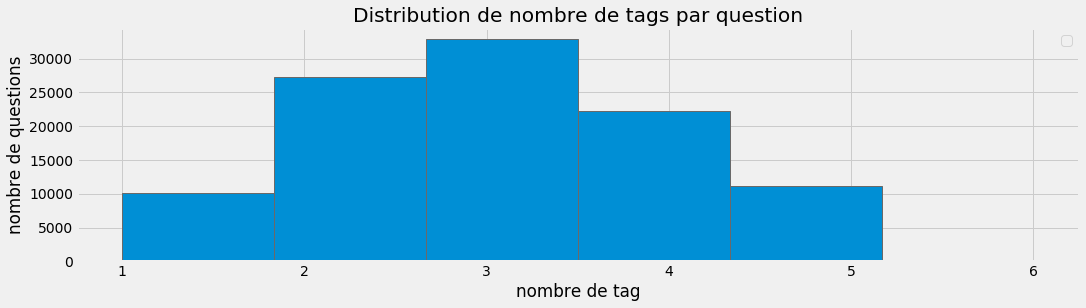

In [21]:
ax = plt.figure(figsize=(16, 4))

plt.hist(df['ntags'], bins=6)

plt.title(u"Distribution de nombre de tags par question")
plt.xlabel(u"nombre de tag")
plt.ylabel(u"nombre de questions")

plt.legend()

[]

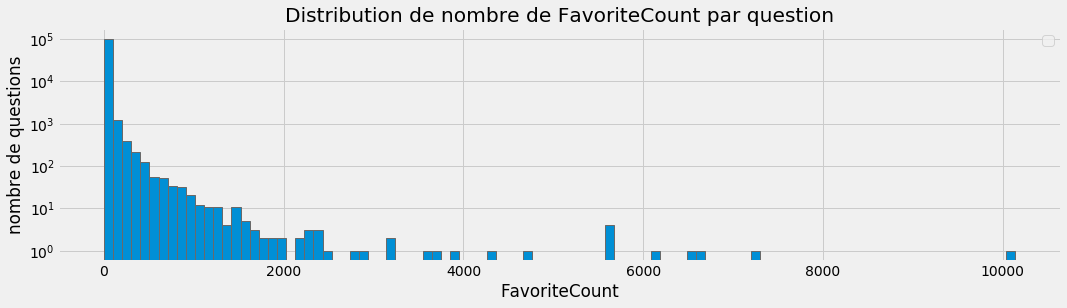

In [22]:
ax = plt.figure(figsize=(16, 4))

plt.hist(df['FavoriteCount'], bins=100)

plt.title(u"Distribution de nombre de FavoriteCount par question")
plt.xlabel(u"FavoriteCount")
plt.ylabel(u"nombre de questions")

plt.legend()
plt.semilogy()

[]

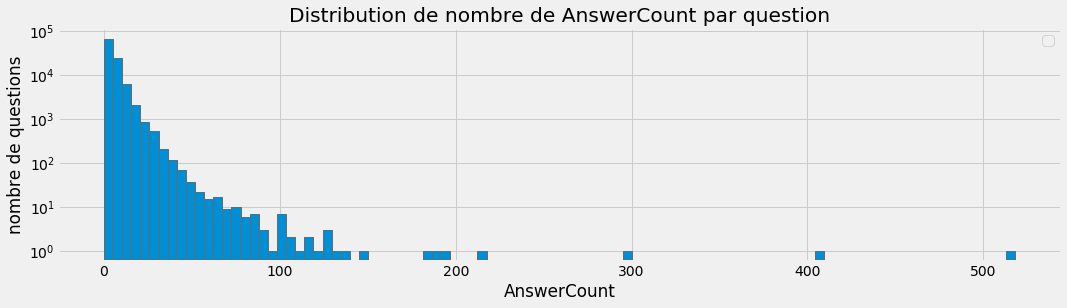

In [23]:
ax = plt.figure(figsize=(16, 4))

plt.hist(df['AnswerCount'], bins=100)

plt.title(u"Distribution de nombre de AnswerCount par question")
plt.xlabel(u"AnswerCount")
plt.ylabel(u"nombre de questions")

plt.legend()
plt.semilogy()

In [24]:
df.tags[0]

['c#', 'floating-point', 'type-conversion', 'double', 'decimal']

In [25]:
tagsfreq = {}
for sentence in tqdm(df.tags):
    for token in sentence:
        if token not in tagsfreq.keys():
            tagsfreq[token] = 1
        else:
            tagsfreq[token] += 1

100%|██████████| 103676/103676 [00:00<00:00, 638046.78it/s]


In [26]:
{k: v for k, v in sorted(tagsfreq.items(),\
                         key=lambda item: item[1], reverse=True)}

{'c#': 14725,
 '.net': 9511,
 'java': 8160,
 'c++': 5759,
 'asp.net': 5526,
 'javascript': 5165,
 'python': 4742,
 'php': 4212,
 'sql': 3388,
 'sql-server': 3036,
 'jquery': 2716,
 'iphone': 2552,
 'html': 2497,
 'c': 2406,
 'windows': 2403,
 'asp.net-mvc': 2192,
 'wpf': 2137,
 'mysql': 2123,
 'database': 1933,
 'ruby': 1773,
 'ruby-on-rails': 1758,
 'visual-studio': 1752,
 'css': 1736,
 'performance': 1590,
 'xml': 1547,
 'linux': 1524,
 'objective-c': 1441,
 'winforms': 1410,
 'algorithm': 1273,
 'vb.net': 1243,
 'multithreading': 1228,
 'svn': 1202,
 'regex': 1172,
 'visual-studio-2008': 1141,
 'linq': 1132,
 'cocoa-touch': 1120,
 'security': 1055,
 'unit-testing': 1031,
 'ajax': 1031,
 'django': 1027,
 'web-services': 1025,
 'language-agnostic': 1025,
 'string': 1020,
 'delphi': 993,
 'oop': 948,
 'user-interface': 931,
 'debugging': 909,
 'wcf': 907,
 'perl': 906,
 'eclipse': 883,
 'cocoa': 881,
 'sql-server-2005': 876,
 'winapi': 865,
 'version-control': 865,
 'macos': 862,
 'ora

2020-02-02 09:49:07,018 :INFO : 1:43: E502 the backslash is redundant between brackets


In [27]:
len(tagsfreq)

12403

## Data Cleaning

### stop words 

In [28]:
engstpw = nltk.corpus.stopwords.words('english')

In [29]:
def clean_from_stop_words(sent):
    return [token for token in sent if token not in engstpw]

In [30]:
df.tokens = df['tokens'].apply(clean_from_stop_words)
df.title_tokens = df['title_tokens'].apply(clean_from_stop_words)

In [31]:
df

,Body,Title,Tags,AnswerCount,FavoriteCount,tokens,title_tokens,tags,ntags
0,I want to use a track-bar to change a form's o...,Convert Decimal to Double,<c#><floating-point><type-conversion><double><...,13,50,"[want, use, track-bar, change, form's, opacity...","[convert, decimal, double]","[c#, floating-point, type-conversion, double, ...",5
1,I have an absolutely positioned div containing...,Percentage width child element in absolutely p...,<html><css><internet-explorer-7>,6,11,"[absolutely, positioned, div, containing, seve...","[percentage, width, child, element, absolutely...","[html, css, internet-explorer-7]",3
2,Given a DateTime representing a person's birth...,How do I calculate someone's age in C#?,<c#><.net><datetime>,61,443,"[given, datetime, representing, person's, birt...","[calculate, someone's, age, c#?]","[c#, .net, datetime]",3
3,"Given a specific DateTime value, how do I disp...",Calculate relative time in C#,<c#><datetime><time><datediff><relative-time-s...,37,540,"[given, specific, datetime, value,, display, r...","[calculate, relative, time, c#]","[c#, datetime, time, datediff, relative-time-s...",5
4,Is there a standard way for a web server to be...,Determine a user's timezone,<html><browser><timezone><user-agent><timezone...,24,147,"[standard, way, web, server, able, determine, ...","[determine, user's, timezone]","[html, browser, timezone, user-agent, timezone...",5
5,What is the difference between Math.Floor() an...,Difference between Math.Floor() and Math.Trunc...,<.net><math>,10,58,"[difference, math.floor(), math.truncate(), .n...","[difference, math.floor(), math.truncate()]","[.net, math]",2
6,How do you expose a LINQ query as an ASMX web ...,Filling a DataSet or DataTable from a LINQ que...,<c#><linq><web-services><.net-3.5>,7,14,"[expose, linq, query, asmx, web, service?, usu...","[filling, dataset, datatable, linq, query, res...","[c#, linq, web-services, .net-3.5]",4
7,How do I store binary data in MySQL?\n,Binary Data in MySQL,<mysql><database><binary-data><data-storage>,9,20,"[store, binary, data, mysql?]","[binary, data, mysql]","[mysql, database, binary-data, data-storage]",4
8,I'm looking for the fastest way to obtain the ...,What is the fastest way to get the value of π?,<performance><algorithm><language-agnostic><un...,23,80,"[i'm, looking, fastest, way, obtain, value, π,...","[fastest, way, get, value, π?]","[performance, algorithm, language-agnostic, un...",5
9,If I have a trigger before the update on a tab...,Throw an error in a MySQL trigger,<mysql><database><triggers>,6,25,"[trigger, update, table,, throw, error, preven...","[throw, error, mysql, trigger]","[mysql, database, triggers]",3


### Lemmatization 

In [32]:
# Create lemmatizer 
lemmatizer = WordNetLemmatizer() 

2020-02-02 09:49:27,175 :INFO : 1:20: W291 trailing whitespace
2020-02-02 09:49:27,176 :INFO : 2:33: W291 trailing whitespace


In [35]:
# Create a list to store the body data
ltokens = []

# For each row in the column,
for row in tqdm(df.tokens):
    lemmed = []
    for word in row:
        lemmed.append(lemmatizer.lemmatize(word))
    ltokens.append(lemmed)

# Create a column from the list
df['tokens'] = ltokens

100%|██████████| 103676/103676 [00:27<00:00, 3789.08it/s]


In [36]:
# Create a list to store the body data
lttokens = []

# For each row in the column,
for row in tqdm(df.title_tokens):
    lemmed = []
    for word in row:
        lemmed.append(lemmatizer.lemmatize(word))
    lttokens.append(lemmed)

# Create a column from the list
df['title_tokens'] = lttokens

100%|██████████| 103676/103676 [00:02<00:00, 39405.61it/s]


In [37]:
df.head()

,Body,Title,Tags,AnswerCount,FavoriteCount,tokens,title_tokens,tags,ntags
0,I want to use a track-bar to change a form's o...,Convert Decimal to Double,<c#><floating-point><type-conversion><double><...,13,50,"[want, use, track-bar, change, form's, opacity...","[convert, decimal, double]","[c#, floating-point, type-conversion, double, ...",5
1,I have an absolutely positioned div containing...,Percentage width child element in absolutely p...,<html><css><internet-explorer-7>,6,11,"[absolutely, positioned, div, containing, seve...","[percentage, width, child, element, absolutely...","[html, css, internet-explorer-7]",3
2,Given a DateTime representing a person's birth...,How do I calculate someone's age in C#?,<c#><.net><datetime>,61,443,"[given, datetime, representing, person's, birt...","[calculate, someone's, age, c#?]","[c#, .net, datetime]",3
3,"Given a specific DateTime value, how do I disp...",Calculate relative time in C#,<c#><datetime><time><datediff><relative-time-s...,37,540,"[given, specific, datetime, value,, display, r...","[calculate, relative, time, c#]","[c#, datetime, time, datediff, relative-time-s...",5
4,Is there a standard way for a web server to be...,Determine a user's timezone,<html><browser><timezone><user-agent><timezone...,24,147,"[standard, way, web, server, able, determine, ...","[determine, user's, timezone]","[html, browser, timezone, user-agent, timezone...",5


### stemming 

In [38]:
# Create p_stemmer of class PorterStemmer
p_stemmer = PorterStemmer()

In [39]:
# Create a list to store the body data
stokens = []

# For each row in the column,
for row in tqdm(df.tokens):
    stemmed = []
    for word in row:
        stemmed.append(p_stemmer.stem(word))
    stokens.append(stemmed)

# Create a column from the list
df['tokens'] = stokens

100%|██████████| 103676/103676 [02:03<00:00, 840.45it/s]


In [40]:
# Create a list to store the body data
sttokens = []

# For each row in the column,
for row in tqdm(df.title_tokens):
    stemmed = []
    for word in row:
        stemmed.append(p_stemmer.stem(word))
    sttokens.append(stemmed)

# Create a column from the list
df['title_tokens'] = sttokens

100%|██████████| 103676/103676 [00:10<00:00, 10037.10it/s]


In [41]:
df.head()

,Body,Title,Tags,AnswerCount,FavoriteCount,tokens,title_tokens,tags,ntags
0,I want to use a track-bar to change a form's o...,Convert Decimal to Double,<c#><floating-point><type-conversion><double><...,13,50,"[want, use, track-bar, chang, form', opacity.,...","[convert, decim, doubl]","[c#, floating-point, type-conversion, double, ...",5
1,I have an absolutely positioned div containing...,Percentage width child element in absolutely p...,<html><css><internet-explorer-7>,6,11,"[absolut, posit, div, contain, sever, children...","[percentag, width, child, element, absolut, po...","[html, css, internet-explorer-7]",3
2,Given a DateTime representing a person's birth...,How do I calculate someone's age in C#?,<c#><.net><datetime>,61,443,"[given, datetim, repres, person', birthday,, c...","[calcul, someone', age, c#?]","[c#, .net, datetime]",3
3,"Given a specific DateTime value, how do I disp...",Calculate relative time in C#,<c#><datetime><time><datediff><relative-time-s...,37,540,"[given, specif, datetim, value,, display, rel,...","[calcul, rel, time, c#]","[c#, datetime, time, datediff, relative-time-s...",5
4,Is there a standard way for a web server to be...,Determine a user's timezone,<html><browser><timezone><user-agent><timezone...,24,147,"[standard, way, web, server, abl, determin, us...","[determin, user', timezon]","[html, browser, timezone, user-agent, timezone...",5


### Creating Bigrams and Trigrams

After many tries I chose thes parameteres, The evaluation method is below 

In [42]:
df['t'] = df['title_tokens'] + df['tokens']

In [43]:
# Build the bigram and trigram models
# higher threshold fewer phrases.
bigram = gensim.models.Phrases(df.t, min_count=5, threshold=50)
trigram = gensim.models.Phrases(bigram[df.t], threshold=50)

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

In [44]:
def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]


def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

In [45]:
df.t = make_trigrams(df.t)

Evaluation :

In [46]:
# Create a list to store the data
sentences = []

# For each row in the column,
for row in tqdm(df.t):
    sentences.append(TreebankWordDetokenizer().detokenize(row))

# Create a column from the list
df['sentence'] = sentences

100%|██████████| 103676/103676 [00:31<00:00, 3289.06it/s]


In [47]:
df[df.sentence.str.contains("_")]

,Body,Title,Tags,AnswerCount,FavoriteCount,tokens,title_tokens,tags,ntags,t,sentence
0,I want to use a track-bar to change a form's o...,Convert Decimal to Double,<c#><floating-point><type-conversion><double><...,13,50,"[want, use, track-bar, chang, form', opacity.,...","[convert, decim, doubl]","[c#, floating-point, type-conversion, double, ...",5,"[convert, decim, doubl, want, use, track-bar, ...",convert decim doubl want use track-bar chang f...
1,I have an absolutely positioned div containing...,Percentage width child element in absolutely p...,<html><css><internet-explorer-7>,6,11,"[absolut, posit, div, contain, sever, children...","[percentag, width, child, element, absolut, po...","[html, css, internet-explorer-7]",3,"[percentag, width, child, element, absolut_pos...",percentag width child element absolut_posit pa...
3,"Given a specific DateTime value, how do I disp...",Calculate relative time in C#,<c#><datetime><time><datediff><relative-time-s...,37,540,"[given, specif, datetim, value,, display, rel,...","[calcul, rel, time, c#]","[c#, datetime, time, datediff, relative-time-s...",5,"[calcul, rel, time, c#, given, specif, datetim...","calcul rel time c# given specif datetim value,..."
4,Is there a standard way for a web server to be...,Determine a user's timezone,<html><browser><timezone><user-agent><timezone...,24,147,"[standard, way, web, server, abl, determin, us...","[determin, user', timezon]","[html, browser, timezone, user-agent, timezone...",5,"[determin, user', timezon, standard, way, web,...",determin user' timezon standard way web server...
6,How do you expose a LINQ query as an ASMX web ...,Filling a DataSet or DataTable from a LINQ que...,<c#><linq><web-services><.net-3.5>,7,14,"[expos, linq, queri, asmx, web, service?, usua...","[fill, dataset, datat, linq, queri, result, set]","[c#, linq, web-services, .net-3.5]",4,"[fill, dataset_datat, linq_queri, result, set,...",fill dataset_datat linq_queri result set expos...
8,I'm looking for the fastest way to obtain the ...,What is the fastest way to get the value of π?,<performance><algorithm><language-agnostic><un...,23,80,"[i'm, look, fastest, way, obtain, valu, π,, pe...","[fastest, way, get, valu, π?]","[performance, algorithm, language-agnostic, un...",5,"[fastest_way, get, valu, π?, i'm, look, fastes...",fastest_way get valu π? i'm look fastest_way o...
10,I'm having issues getting the C sockets API to...,How to use the C socket API in C++ on z/OS,<c++><c><sockets><mainframe><zos>,9,7,"[i'm, issu, get, c, socket, api, work, properl...","[use, c, socket, api, c++, z/o]","[c++, c, sockets, mainframe, zos]",5,"[use, c, socket, api, c++, z/o, i'm, issu, get...",use c socket api c++ z/o i'm issu get c socket...
11,How do I forcefully unload a ByteArray from me...,Unloading a ByteArray using Actionscript 3,<arrays><actionscript-3><apache-flex>,8,2,"[forc, unload, bytearray, memori, use, actions...","[unload, bytearray, use, actionscript, 3]","[arrays, actionscript-3, apache-flex]",3,"[unload, bytearray, use, actionscript_3, forc,...",unload bytearray use actionscript_3 forc unloa...
12,How can I monitor an SQL Server database for c...,Check for changes to an SQL Server table?,<sql><sql-server><datatable><rdbms>,8,25,"[monitor, sql, server, databas, chang, tabl, w...","[check, chang, sql, server, table?]","[sql, sql-server, datatable, rdbms]",4,"[check, chang, sql_server, table?, monitor, sq...",check chang sql_server table? monitor sql_serv...
13,I am aware that in .NET there are three timer ...,Reliable timer in a console application,<c#><.net><vb.net><timer>,2,3,"[awar, .net, three, timer, type, (see, compar,...","[reliabl, timer, consol, applic]","[c#, .net, vb.net, timer]",4,"[reliabl, timer, consol, applic, awar, .net, t...",reliabl timer consol applic awar .net three ti...


In [48]:
bigrams = []

for row in tqdm(df[df.sentence.str.contains("_")].sentence):
    for word in row.split():
        if word not in bigrams and "_" in word:
            bigrams.append(word)

100%|██████████| 89123/89123 [51:07<00:00, 29.05it/s]  


In [49]:
len(bigrams)

83033

In [50]:
bigrams

['follow_error:',
 'cannot_implicitli_convert',
 'work_fine',
 'absolut_posit',
 'internet_explor_7',
 'absolut_posit_div',
 'ie7,_firefox',
 'miss_here?',
 'hour_ago',
 'day_ago',
 'month_ago',
 'web_page?',
 'http_header',
 'dataset_datat',
 'linq_queri',
 'asmx_web',
 'linq_query?',
 'public_static',
 'fastest_way',
 'm_pi,',
 '#includ_<math.h>',
 '#includ_<stdio.h>',
 '#includ_<time.h>',
 '=_0;_<',
 'm_pi;',
 'diffclock(clock_t',
 'clock_t',
 '/_clocks_per_sec;}',
 'int_main()_{',
 'int_i;',
 "m_pi''",
 'defined(__gnuc__)',
 '(defined(__i386__)',
 'defined(__amd64__))',
 '#endif_/*',
 'x86_x64',
 'gcc_-o3',
 '-wall_-c',
 'gcc_-o3_-wall',
 '32-bit_64-bit',
 'af_inet',
 'miss_someth',
 'upon_investigation,',
 '_oe_socket',
 'af_inet;}',
 'inet_test',
 '"af_inet"',
 'far_tell,',
 '__cplusplu',
 'extern_"c"',
 'actionscript_3',
 'actionscript_3?',
 'i++_)_{',
 'sql_server',
 "i'd_like",
 'sql_server_2000',
 'binary_checksum',
 'follow_query:_select',
 'checksum_agg(binary_checksum(*))'

## TF-IDF

In [105]:
# Create a list to store the data
tsentences = []

# For each row in the column,
for row in tqdm(df.tags):
    tsentences.append(TreebankWordDetokenizer().detokenize(row))

# Create a column from the list
df['tsentence'] = tsentences

100%|██████████| 103676/103676 [00:05<00:00, 20350.60it/s]


In [106]:
df.head()

,Body,Title,Tags,AnswerCount,FavoriteCount,tokens,title_tokens,tags,ntags,t,sentence,tsentence
0,I want to use a track-bar to change a form's o...,Convert Decimal to Double,<c#><floating-point><type-conversion><double><...,13,50,"[want, use, track-bar, chang, form', opacity.,...","[convert, decim, doubl]","[c#, floating-point, type-conversion, double, ...",5,"[convert, decim, doubl, want, use, track-bar, ...",convert decim doubl want use track-bar chang f...,c# floating-point type-conversion double decimal
1,I have an absolutely positioned div containing...,Percentage width child element in absolutely p...,<html><css><internet-explorer-7>,6,11,"[absolut, posit, div, contain, sever, children...","[percentag, width, child, element, absolut, po...","[html, css, internet-explorer-7]",3,"[percentag, width, child, element, absolut_pos...",percentag width child element absolut_posit pa...,html css internet-explorer-7
2,Given a DateTime representing a person's birth...,How do I calculate someone's age in C#?,<c#><.net><datetime>,61,443,"[given, datetim, repres, person', birthday,, c...","[calcul, someone', age, c#?]","[c#, .net, datetime]",3,"[calcul, someone', age, c#?, given, datetim, r...",calcul someone' age c#? given datetim repres p...,c# .net datetime
3,"Given a specific DateTime value, how do I disp...",Calculate relative time in C#,<c#><datetime><time><datediff><relative-time-s...,37,540,"[given, specif, datetim, value,, display, rel,...","[calcul, rel, time, c#]","[c#, datetime, time, datediff, relative-time-s...",5,"[calcul, rel, time, c#, given, specif, datetim...","calcul rel time c# given specif datetim value,...",c# datetime time datediff relative-time-span
4,Is there a standard way for a web server to be...,Determine a user's timezone,<html><browser><timezone><user-agent><timezone...,24,147,"[standard, way, web, server, abl, determin, us...","[determin, user', timezon]","[html, browser, timezone, user-agent, timezone...",5,"[determin, user', timezon, standard, way, web,...",determin user' timezon standard way web server...,html browser timezone user-agent timezone-offset


In [158]:
df.to_csv(r'C:/Users/ayoub/OCP6 Data//df.csv', header=True, index=None, sep=',')

2020-02-02 12:46:11,691 :INFO : 1:80: E501 line too long (80 > 79 characters)


In [149]:
Cvectorizer = CountVectorizer(tokenizer=lambda x: x.split(' '), max_df=0.5, min_df=10)
Tvectorizer = TfidfVectorizer(tokenizer=lambda x: x.split(' '), max_df=0.5, min_df=10)

2020-02-02 12:35:30,345 :INFO : 1:80: E501 line too long (86 > 79 characters)
2020-02-02 12:35:30,347 :INFO : 2:80: E501 line too long (86 > 79 characters)


In [152]:
X_C = Cvectorizer.fit_transform(df.sentence)
X_T = Tvectorizer.fit_transform(df.sentence)

In [153]:
X_C_columns = Cvectorizer.get_feature_names()
X_T_columns = Tvectorizer.get_feature_names()

In [154]:
scipy.sparse.save_npz(r'C:/Users/ayoub/OCP6 Data//X_C.npz', X_C)
scipy.sparse.save_npz(r'C:/Users/ayoub/OCP6 Data//X_T.npz', X_T)
with open("C:/Users/ayoub/OCP6 Data/X_C_columns.txt", "wb") as fp:
    pickle.dump(X_C_columns, fp)
with open("C:/Users/ayoub/OCP6 Data/X_T_columns.txt", "wb") as fp:
    pickle.dump(X_T_columns, fp)

In [155]:
Y_C = Cvectorizer.fit_transform(df.tsentence)
Y_T = Tvectorizer.fit_transform(df.tsentence)

In [156]:
Y_C_columns = Cvectorizer.get_feature_names()
Y_T_columns = Tvectorizer.get_feature_names()

In [157]:
scipy.sparse.save_npz(r'C:/Users/ayoub/OCP6 Data//Y_C.npz', Y_C)
scipy.sparse.save_npz(r'C:/Users/ayoub/OCP6 Data//Y_T.npz', Y_T)
with open("C:/Users/ayoub/OCP6 Data/Y_C_columns.txt", "wb") as fp:
    pickle.dump(Y_C_columns, fp)
with open("C:/Users/ayoub/OCP6 Data/Y_T_columns.txt", "wb") as fp:
    pickle.dump(Y_T_columns, fp)

# Brouillon

### Manual TF_IDF

In [ ]:
wordfreq = {}
for sentence in tqdm(df.t):
    for token in sentence:
        if token not in wordfreq.keys():
            wordfreq[token] = 1
        else:
            wordfreq[token] += 1

In [ ]:
len(wordfreq)

In [ ]:
word_idf_values = {}
for token in tqdm(wordfreq):
    doc_containing_word = 0
    for sentence in df.t:
        if token in sentence:
            doc_containing_word += 1
    word_idf_values[token] = np.log(len(df.t)/(1 + doc_containing_word))

In [ ]:
len(word_idf_values)

In [ ]:
word_tf_values = {}
for token in tqdm(wordfreq):
    sent_tf_vector = []
    for sentence in df.t:
        doc_freq = 0
        for word in sentence:
            if token == word:
                  doc_freq += 1
        word_tf = doc_freq/len(sentence)
        sent_tf_vector.append(word_tf)
    word_tf_values[token] = sent_tf_vector

In [ ]:
tfidf_values = []
for token in tqdm(word_tf_values.keys()):
    tfidf_sentences = []
    for tf_sentence in word_tf_values[token]:
        tf_idf_score = tf_sentence * word_idf_values[token]
        tfidf_sentences.append(tf_idf_score)
    tfidf_values.append(tfidf_sentences)

In [ ]:
tf_model = np.asarray(word_tf_values)
tf_idf_model = np.asarray(tfidf_values)
tf_idf_model.shape

## More cleaning

In [ ]:
n_punc = [item for item in list(string.punctuation) if item not in ['#', '+', '-', '.']]

In [ ]:
def clean_from_stop_n_punc(sent):
    return [token for token in sent if token not in n_punc]

In [ ]:
result = list(string.punctuation)
print(result)

In [ ]:
from collections import Counter
Counter(df.tokens[0]+ df.tokens[1]).most_common()

In [146]:
n_punc = ['#', '+', '-', '.']

### Other

In [148]:
with open("C:/Users/ayoub/OCP6 Data/test.txt", "wb") as fp:
    pickle.dump(n_punc, fp)

In [107]:
df_test = df[:100]

In [108]:
df_test

,Body,Title,Tags,AnswerCount,FavoriteCount,tokens,title_tokens,tags,ntags,t,sentence,tsentence
0,I want to use a track-bar to change a form's o...,Convert Decimal to Double,<c#><floating-point><type-conversion><double><...,13,50,"[want, use, track-bar, chang, form', opacity.,...","[convert, decim, doubl]","[c#, floating-point, type-conversion, double, ...",5,"[convert, decim, doubl, want, use, track-bar, ...",convert decim doubl want use track-bar chang f...,c# floating-point type-conversion double decimal
1,I have an absolutely positioned div containing...,Percentage width child element in absolutely p...,<html><css><internet-explorer-7>,6,11,"[absolut, posit, div, contain, sever, children...","[percentag, width, child, element, absolut, po...","[html, css, internet-explorer-7]",3,"[percentag, width, child, element, absolut_pos...",percentag width child element absolut_posit pa...,html css internet-explorer-7
2,Given a DateTime representing a person's birth...,How do I calculate someone's age in C#?,<c#><.net><datetime>,61,443,"[given, datetim, repres, person', birthday,, c...","[calcul, someone', age, c#?]","[c#, .net, datetime]",3,"[calcul, someone', age, c#?, given, datetim, r...",calcul someone' age c#? given datetim repres p...,c# .net datetime
3,"Given a specific DateTime value, how do I disp...",Calculate relative time in C#,<c#><datetime><time><datediff><relative-time-s...,37,540,"[given, specif, datetim, value,, display, rel,...","[calcul, rel, time, c#]","[c#, datetime, time, datediff, relative-time-s...",5,"[calcul, rel, time, c#, given, specif, datetim...","calcul rel time c# given specif datetim value,...",c# datetime time datediff relative-time-span
4,Is there a standard way for a web server to be...,Determine a user's timezone,<html><browser><timezone><user-agent><timezone...,24,147,"[standard, way, web, server, abl, determin, us...","[determin, user', timezon]","[html, browser, timezone, user-agent, timezone...",5,"[determin, user', timezon, standard, way, web,...",determin user' timezon standard way web server...,html browser timezone user-agent timezone-offset
5,What is the difference between Math.Floor() an...,Difference between Math.Floor() and Math.Trunc...,<.net><math>,10,58,"[differ, math.floor(), math.truncate(), .net?]","[differ, math.floor(), math.truncate()]","[.net, math]",2,"[differ, math.floor(), math.truncate(), differ...",differ math.floor() math.truncate() differ mat...,.net math
6,How do you expose a LINQ query as an ASMX web ...,Filling a DataSet or DataTable from a LINQ que...,<c#><linq><web-services><.net-3.5>,7,14,"[expos, linq, queri, asmx, web, service?, usua...","[fill, dataset, datat, linq, queri, result, set]","[c#, linq, web-services, .net-3.5]",4,"[fill, dataset_datat, linq_queri, result, set,...",fill dataset_datat linq_queri result set expos...,c# linq web-services .net-3.5
7,How do I store binary data in MySQL?\n,Binary Data in MySQL,<mysql><database><binary-data><data-storage>,9,20,"[store, binari, data, mysql?]","[binari, data, mysql]","[mysql, database, binary-data, data-storage]",4,"[binari, data, mysql, store, binari, data, mys...",binari data mysql store binari data mysql?,mysql database binary-data data-storage
8,I'm looking for the fastest way to obtain the ...,What is the fastest way to get the value of π?,<performance><algorithm><language-agnostic><un...,23,80,"[i'm, look, fastest, way, obtain, valu, π,, pe...","[fastest, way, get, valu, π?]","[performance, algorithm, language-agnostic, un...",5,"[fastest_way, get, valu, π?, i'm, look, fastes...",fastest_way get valu π? i'm look fastest_way o...,performance algorithm language-agnostic unix pi
9,If I have a trigger before the update on a tab...,Throw an error in a MySQL trigger,<mysql><database><triggers>,6,25,"[trigger, updat, table,, throw, error, prevent...","[throw, error, mysql, trigger]","[mysql, database, triggers]",3,"[throw, error, mysql, trigger, trigger, updat,...","throw error mysql trigger trigger updat tab

In [88]:
vectorizer = CountVectorizer()
vectorizer = TfidfVectorizer(max_df=0.2)
tfidf_vectorizer = TfidfTransformer()

In [89]:
X = vectorizer.fit_transform(df_test.sentence)

In [63]:
df_test['yo'] = list(X).toarray()

C:\Users\ayoub\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [64]:
df_test

,Body,Title,Tags,AnswerCount,FavoriteCount,tokens,title_tokens,tags,ntags,t,sentence,yo
0,I want to use a track-bar to change a form's o...,Convert Decimal to Double,<c#><floating-point><type-conversion><double><...,13,50,"[want, use, track-bar, chang, form', opacity.,...","[convert, decim, doubl]","[c#, floating-point, type-conversion, double, ...",5,"[convert, decim, doubl, want, use, track-bar, ...",convert decim doubl want use track-bar chang f...,"(0, 1438)\t1\n (0, 1221)\t1\n (0, 1961)\t1..."
1,I have an absolutely positioned div containing...,Percentage width child element in absolutely p...,<html><css><internet-explorer-7>,6,11,"[absolut, posit, div, contain, sever, children...","[percentag, width, child, element, absolut, po...","[html, css, internet-explorer-7]",3,"[percentag, width, child, element, absolut_pos...",percentag width child element absolut_posit pa...,"(0, 445)\t1\n (0, 1697)\t1\n (0, 455)\t1\n..."
2,Given a DateTime representing a person's birth...,How do I calculate someone's age in C#?,<c#><.net><datetime>,61,443,"[given, datetim, repres, person', birthday,, c...","[calcul, someone', age, c#?]","[c#, .net, datetime]",3,"[calcul, someone', age, c#?, given, datetim, r...",calcul someone' age c#? given datetim repres p...,"(0, 2061)\t1\n (0, 250)\t1\n (0, 1357)\t1\..."
3,"Given a specific DateTime value, how do I disp...",Calculate relative time in C#,<c#><datetime><time><datediff><relative-time-s...,37,540,"[given, specif, datetim, value,, display, rel,...","[calcul, rel, time, c#]","[c#, datetime, time, datediff, relative-time-s...",5,"[calcul, rel, time, c#, given, specif, datetim...","calcul rel time c# given specif datetim value,...","(0, 1184)\t1\n (0, 486)\t1\n (0, 889)\t1\n..."
4,Is there a standard way for a web server to be...,Determine a user's timezone,<html><browser><timezone><user-agent><timezone...,24,147,"[standard, way, web, server, abl, determin, us...","[determin, user', timezon]","[html, browser, timezone, user-agent, timezone...",5,"[determin, user', timezon, standard, way, web,...",determin user' timezon standard way web server...,"(0, 1742)\t1\n (0, 110)\t1\n (0, 1334)\t1\..."
5,What is the difference between Math.Floor() an...,Difference between Math.Floor() and Math.Trunc...,<.net><math>,10,58,"[differ, math.floor(), math.truncate(), .net?]","[differ, math.floor(), math.truncate()]","[.net, math]",2,"[differ, math.floor(), math.truncate(), differ...",differ math.floor() math.truncate() differ mat...,"(0, 1885)\t2\n (0, 734)\t2\n (0, 1135)\t4\..."
6,How do you expose a LINQ query as an ASMX web ...,Filling a DataSet or DataTable from a LINQ que...,<c#><linq><web-services><.net-3.5>,7,14,"[expos, linq, queri, asmx, web, service?, usua...","[fill, dataset, datat, linq, queri, result, set]","[c#, linq, web-services, .net-3.5]",4,"[fill, dataset_datat, linq_queri, result, set,...",fill dataset_datat linq_queri result set expos...,"(0, 1613)\t1\n (0, 124)\t1\n (0, 481)\t1\n..."
7,How do I store binary data in MySQL?\n,Binary Data in MySQL,<mysql><database><binary-data><data-storage>,9,20,"[store, binari, data, mysql?]","[binari, data, mysql]","[mysql, database, binary-data, data-storage]",4,"[binari, data, mysql, store, binari, data, mys...",binari data mysql store binari data mysql?,"(0, 1733)\t1\n (0, 1208)\t2\n (0, 472)\t2\..."
8,I'm looking for the fastest way to obtain the ...,What is the fastest way to get the value of π?,<performance><algorithm><language-agnostic><un...,23,80,"[i'm, look, fastest, way, obtain, valu, π,, pe...","[fastest, way, get, valu, π?]","[performance, algorithm, language-agnostic, un...",5,"[fastest_way, get, valu, π?, i'm, look, fastes...",fastest_way get valu π? i'm look fastest_way o...,"(0, 645)\t1\n (0, 1860)\t1\n (0, 376)\t1\n..."
9,If I have a trigger before the update on a tab...,Throw an error in a MySQL trigger,<mysql><database><triggers>,6,25,"[trigger, updat, table,, throw, error, prevent...","[throw, error, mysql, trigger]","[mysql, database, t

In [66]:
X.toarray()

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

In [131]:
vectorizer = TfidfVectorizer(tokenizer=lambda x: x.split(' '))
X = vectorizer.fit_transform(df_test.tsentence)

In [132]:
X.shape

(100, 199)

In [133]:
vectorizer.get_feature_names()

['.net',
 '.net-3.5',
 '64-bit',
 'actionscript-3',
 'active-directory',
 'air',
 'algorithm',
 'analytics',
 'apache',
 'apache-flex',
 'aptana',
 'architecture',
 'arrays',
 'article',
 'asp-classic',
 'asp.net',
 'authentication',
 'bcp',
 'berkeley-db',
 'binary-data',
 'bpgsql',
 'branch',
 'branching-and-merging',
 'browser',
 'c',
 'c#',
 'c++',
 'casting',
 'collaboration',
 'color-space',
 'colors',
 'com',
 'com-interop',
 'compatibility',
 'compiler-construction',
 'compression',
 'continuous-integration',
 'crash',
 'cross-platform',
 'cruisecontrol.net',
 'css',
 'csv',
 'cx-oracle',
 'data-binding',
 'data-conversion',
 'data-storage',
 'database',
 'datatable',
 'datediff',
 'datetime',
 'db2',
 'debugging',
 'decimal',
 'deployment',
 'dictionary',
 'django',
 'documentation',
 'double',
 'download',
 'eclipse',
 'email',
 'email-spam',
 'embed',
 'embedded-database',
 'encryption',
 'exchange-server',
 'extreme-programming',
 'file',
 'file-type',
 'flat-file',
 'float

In [100]:
X.toarray()

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

In [101]:
pd.DataFrame(X.toarray(), columns = vectorizer.get_feature_names()) 

,10,100,1000,10000,1000000,10000000,1047,116,126,132,133,13563,16,1kb,20,2000,2005,2006,2008,2017,250,30,300,3049,32,32_bit,37,379,38,380,39,3940,3rd,40,400,41,43,44,45,48,50,500,5000,52,543,56,64,64_bit,64bit,679,76,945,9594,_0,_1,___ie_printtyp,__amd64__,__cplusplu,__gnuc__,__i386__,_actioncontroller,_afxdll,_b,_best_way,_case,_clocks_per_sec,_deal,_firefox,_link,_oe_socket,_posit,_sans,_say,_select,abil,abl,abnorm,above,absolut_minimum,absolut_posit,absolut_posit_div,absurd,access,accord_documentation,account,accross,achiev,acos,across,act,action,actioncontroller,actionscript_3,activ_directori,active_support,activesupport,actual,ad,add,address,...,view,views,virtual,virtual_host,virtual_hosts,visitors,vista,visual,visual_studio,visual_studio_2003,visual_studio_2005,void,wall,wall_,want,war_stori,warmup,warn,warning,was,way,wc,we,web,web_page,web_servic,web_service,web_site,webalizer,webbrows,webbrowser,webbrowserreadystate,webdav,websit,websites,week,weekend,welcom,well,went,what,whatever,whenev,wherein,whether,which,whichev,whilst,whole,width,will,win32,win32_api,window,window_forms,window_medium_player,window_nt,window_vista,window_xp,windows,winform,winner,with,within,without,wizard,wl,wmp,wmv,wonder,word,words,work,work_fine,workaround,works,world_experi,worri,would,wpd,write,written,written_c,wrong,x86_x64,xml,xml_document,xplink,xslt,year,years,yes,yet,yield,you,youtub,youtub_video,youtube,zendcor,zeu
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,6,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
6,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,

2020-02-02 11:44:25,457 :INFO : 1:34: E251 unexpected spaces around keyword / parameter equals
2020-02-02 11:44:25,458 :INFO : 1:36: E251 unexpected spaces around keyword / parameter equals
2020-02-02 11:44:25,459 :INFO : 1:68: W291 trailing whitespace
